In [1]:
import torchinfo
import torch


from progamer import ProGamer

import pandas as pd
from jetnet.evaluation import w1p, w1efp, w1m, cov_mmd,fpnd
from jetnet.datasets import JetNet
# from main import train
import sys
sys.path.insert(1,"/home/kaechben/plots")

from plots import plotting_point_cloud, set_pastel
sys.path.insert(1,"/beegfs/desy/user/kaechben/code")



pd.set_option("display.max_colwidth",200)
import matplotlib.pyplot as plt
import os
import hist
import mplhep as hep
import torch
import numpy as np
import hist
from hist import Hist
import traceback
import pandas as pd
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams['lines.linewidth'] = 2
font = {"family": "normal", "weight": "bold", "size": 12}
mpl.rc("font", **font)
config = {
        "val_check": 50,
        "parton": "t",
        "warmup": 1200,
        "sched": "linear",
        "freq": 3,
        "batch_size": 1024,
        "dropout": 0.1,
        "opt": "Adam",
        "lr_g": 0.0001,
        "ratio": 1,
        "l_dim": 25,
        "no_hidden_gen": False,
        "no_hidden": False,
        "hidden": 1024,
        "max_epochs": 3600,
        "name": "plsdontbebetter",
        "n_part": 150,
        "n_dim": 3,
        "heads": 5,
        "wgan": False,
        "flow_prior": True,
        "load_ckpt": "/beegfs/desy/user/kaechben/pointflow_q/epoch=49-val_fpnd=182.38-val_w1m=0.0148-val_w1efp=0.000054-val_w1p=0.00501.ckpt",
         "load_ckpt_trafo":'/beegfs/desy/user/kaechben/pf_t/ProGamer/ppt4j2nb/checkpoints/epoch=7299-fpnd=0.1967163-w1m=0.0011--w1efp=0.000017.ckpt',
        "swa":True,
        "swagen":True,
        "add_corr":True,
        "frac_pretrain":0.0,
        "num_layers":4,
        "normfirst":True,
        "bn":False,
        "featurematching":False,
        "context_features":0
        
    }
#ProGamer.load_from_checkpoint(config["load_ckpt_trafo"])
checkpoint = torch.load(config["load_ckpt_trafo"])
print(checkpoint.keys())

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])


In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.preprocessing import QuantileTransformer
from helpers import *
import jetnet

class StandardScaler:
    def __init__(self, mean=None, std=None, epsilon=1e-7):
        """Standard Scaler.
        The class can be used to normalize PyTorch Tensors using native 
        functions. The module does not expect the tensors to be of any specific shape;
         as long as the features are the last dimension in the tensor, the module
        will work fine.
        :param mean: The mean of the features. The property will be set after a call to fit.
        :param std: The standard deviation of the features. The property will be set after a call to fit.
        :param epsilon: Used to avoid a Division-By-Zero exception.
        """
        self.mean = mean
        self.std = std
        self.epsilon = epsilon

    def fit(self, values):
        dims = list(range(values.dim() - 1))
        self.mean = torch.mean(values, dim=dims)
        self.std = torch.std(values, dim=dims)

    def transform(self, values):
        return (values - self.mean) / (self.std + self.epsilon)

    def inverse_transform(self, values):
        return (values * self.std) + self.mean

    def fit_transform(self, values):
        self.fit(values)
        return self.transform(values)

    def to(self, dev):
        self.std = self.std.to(dev)
        self.mean = self.mean.to(dev)
        return self


import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


class JetNetDataloader(pl.LightningDataModule):
    """This is more or less standard boilerplate coded that builds the data loader of the training
    one thing to note is the custom standard scaler that works on tensors
    Currently only jets with 30 particles are used but this maybe changes soon"""

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.n_dim = config["n_dim"]

        self.n_part = 150
        self.n_current = 150
        self.batch_size = config["batch_size"]
        
        #self.data=self.data[:,:self.n_current,:]
       
        #self.data[:,:,-1] = self.data[:,:,-1][:,:self.n_current].bool()

        # # self.data, self.test_set = train_test_split(self.data.cpu().numpy(), test_size=0.3)
        
    def setup(self, stage):
        # This just sets up the dataloader, nothing particularly important. it reads in a csv, calculates mass and reads out the number particles per jet
        # And adds it to the dataset as variable. The only important thing is that we add noise to zero padded jets
        data,_=jetnet.datasets.JetNet.getData(jet_type=self.config["parton"],split="train",num_particles=self.n_part,data_dir="/beegfs/desy/user/kaechben/datasets")
        test_set,_=jetnet.datasets.JetNet.getData(jet_type=self.config["parton"],split="valid",num_particles=self.n_part,data_dir="/beegfs/desy/user/kaechben/datasets")
        data=torch.tensor(data)
        test_set=torch.tensor(test_set)
        self.data=torch.cat((data,test_set),dim=0)
        self.n = self.data[:,:,-1].sum(axis=1)
        
        self.data[:,:,-1] = ~(self.data[:,:,-1].bool())

        self.scalers=[]
        
        # standard scaling
        
        # self.scaler=StandardScaler()
        # self.data[:,:,:-1]=self.scaler.fit_transform(self.data[:,:,:-1])
        
        # self.data=sorted(self.data.permute(1,2),key=lambda x: len(x[0]>0))
        # self.sorted_lengths = [len(s[0]) for s in self.data]

        return 0
        # self.data = torch.tensor(self.data).float()
        # self.num_batches = len(self.data) // self.config["batch_size"]
        # self.c
        import matplotlib.pyplot as plt
        import seaborn as sns

        # Use plot styling from seaborn.
        sns.set(style='darkgrid')

        # Increase the plot size and font size.
        sns.set(font_scale=1.5)
        plt.rcParams["figure.figsize"] = (12,6)

        plt.plot(range(0, len(sorted_lengths)), sorted_lengths)

        plt.xlabel('Sample Number')
        plt.ylabel('Sequence Length')
        plt.title('Samples after Sorting')

        plt.show()
        self.test_set = self.data[-len(test_set):].float()
        self.data = self.data[:-len(test_set)].float()
        assert (torch.isnan(self.data)).sum() == 0
   
    def train_dataloader(self):
        
        # batch_size={"0":[128],"1":[1024],"31":[512],"50":[128]}

        # if self.n_current<=30:
        #     n="1"
        # elif self.n_current>=50:
        #     n="1"
        # elif self.n_current>=31:
        #     n="1"
        
        
        
        return DataLoader(self.data[:,:self.n_current], batch_size=self.config["batch_size"], drop_last=True,num_workers=40)

    def val_dataloader(self):
        return DataLoader(self.test_set[:,:self.n_part], batch_size=len(self.test_set), drop_last=True,num_workers=40)
    
    def smart_padding(self,data):
        n=data[:,:,-1].sum(1)
        data=data[:].tolist()

        for i in range(len(data[:])):
            del data[i][self.n_part-int(n[i]):]

        data=sorted(data,key=lambda x: len(x))
        sorted_lengths = [len(s) for s in data]

        import random

        # List of batches that we'll construct.
        batch_ordered_sentences = []
        batch_size=self.batch_size
        print('Creating training batches of size {:}'.format(batch_size))

        # Loop over all of the input samples...    
        while len(data) > 0:
            
            # Report progress.
            if ((len(batch_ordered_sentences) % 500) == 0):
                print('  Selected {:,} batches.'.format(len(batch_ordered_sentences)))

            # `to_take` is our actual batch size. It will be `batch_size` until 
            # we get to the last batch, which may be smaller. 
            to_take = min(batch_size, len(data))

            # Pick a random index in the list of remaining samples to start
            # our batch at.
            select = random.randint(0, len(data) - to_take)

            # Select a contiguous batch of samples starting at `select`.
            batch = data[select:(select + to_take)]

            # Each sample is a tuple--split them apart to create a separate list of 
            # sequences and a list of labels for this batch.
            batch_ordered_sentences.append([s for s in batch])
            # batch_ordered_labels.append([s[1] for s in batch])

            # Remove these samples from the list.
            del data[select:select + to_take]

        print('\n  DONE - {:,} batches.'.format(len(batch_ordered_sentences)))
        import torch

        py_inputs = []


        # For each batch...
        for batch_inputs in batch_ordered_sentences:

            # New version of the batch, this time with padded sequences and now with
            # attention masks defined.
            batch_padded_inputs = []
            batch_attn_masks = []
            
            # First, find the longest sample in the batch. 
            # Note that the sequences do currently include the special tokens!
            max_size = max([len(sen) for sen in batch_inputs])

            #print('Max size:', max_size)

            # For each input in this batch...
            for sen in batch_inputs:
                # How many pad tokens do we need to add?
                num_pads = max_size - len(sen)
                
                # Add `num_pads` padding tokens to the end of the sequence.
                padded_input = sen + [[0,0,0,1]]*num_pads

                # Add the padded results to the batch.
                batch_padded_inputs.append(padded_input)
        # break
            # Our batch has been padded, so we need to save this updated batch.
            # We also need the inputs to be PyTorch tensors, so we'll do that here.
            py_inputs.append(torch.tensor(batch_padded_inputs).squeeze(0))
            # py_attn_masks.append(torch.tensor(batch_attn_masks))
        import torch

        py_inputs = []


        # For each batch...
        for batch_inputs in batch_ordered_sentences:

            # New version of the batch, this time with padded sequences and now with
            # attention masks defined.
            batch_padded_inputs = []
            batch_attn_masks = []
            
            # First, find the longest sample in the batch. 
            # Note that the sequences do currently include the special tokens!
            max_size = max([len(sen) for sen in batch_inputs])

            #print('Max size:', max_size)

            # For each input in this batch...
            for sen in batch_inputs:
                # How many pad tokens do we need to add?
                num_pads = max_size - len(sen)
                
                # Add `num_pads` padding tokens to the end of the sequence.
                padded_input = sen + [[0,0,0,1]]*num_pads

                # Add the padded results to the batch.
                batch_padded_inputs.append(padded_input)
        # break
            # Our batch has been padded, so we need to save this updated batch.
            # We also need the inputs to be PyTorch tensors, so we'll do that here.
            py_inputs.append(torch.tensor(batch_padded_inputs))
            return py_inputs
        # py_attn_masks.append(torch.tensor(batch_attn_masks))
        # Get the new list of lengths after sorting.
    #     max_len=150
    #     padded_lengths = []

    #     # For each batch...
    #     for batch in py_inputs:
            
    #         # For each sample...
    #         for s in batch:
            
    #             # Record its length.
    #             padded_lengths.append(len(s))

    #     # Sum up the lengths to the get the total number of tokens after smart batching.
    #     smart_token_count = np.sum(padded_lengths)

    #     # To get the total number of tokens in the dataset using fixed padding, it's
    #     # as simple as the number of samples times our `max_len` parameter (that we
    #     # would pad everything to).
    #     fixed_token_count = len(data) * max_len

    #     # Calculate the percentage reduction.
    #     prcnt_reduced = (fixed_token_count - smart_token_count) / float(fixed_token_count) 

    # #     print('Total tokens:')
    # #     print('   Fixed Padding: {:,}'.format(fixed_token_count))
    # print('  Smart Batching: {:,}  ({:.1%} less)'.format(smart_token_count, prcnt_reduced))

In [4]:

data_module = JetNetDataloader(config,) #this loads the data
data_module.setup("train")
#data=data_module.smart_padding(data_module.data)
# data=data_module.scaler.inverse_transform(data_module.data[:,:90]).reshape(-1,30,3)
# model = TransGan(config,data_module.num_batches)


0

tensor([91, 47, 51,  ..., 53, 45, 73])

(array([  411.,  8298., 31782., 48885., 36711., 17341.,  5776.,  1618.,
          348.,    83.]),
 array([ 10.,  24.,  38.,  52.,  66.,  80.,  94., 108., 122., 136., 150.]),
 <BarContainer object of 10 artists>)

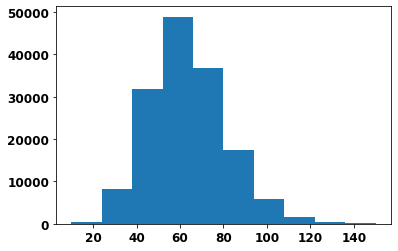

In [36]:
plt.hist((~(data_module.data[:,:,-1].bool())).sum(1).numpy())

In [43]:
from torch.utils.data import DataLoader

k=0
for i in DataLoader(data_module.data,collate_fn=custom_collate,batch_size=128):
    print(i.shape)
    if k>10:
        break
    k+=1

    

torch.Size([128, 100, 4])
torch.Size([128, 108, 4])
torch.Size([128, 111, 4])
torch.Size([128, 105, 4])
torch.Size([128, 116, 4])
torch.Size([128, 112, 4])
torch.Size([128, 109, 4])
torch.Size([128, 121, 4])
torch.Size([128, 119, 4])
torch.Size([128, 106, 4])
torch.Size([128, 114, 4])
torch.Size([128, 143, 4])


In [29]:
from torch.utils.data import Dataset


In [58]:
k=0
def custom_collate(data): #(2)
    print(data[:2])
    data=torch.tensor(data)
    masks=data[0][:,-1]
    sel=torch.ones(len(data),data.sum(1).max())
    inputs = data[sel]
    return inputs
for i in DataLoader(data_module.data,shuffle=True,collate_fn=custom_collate,batch_size=128):
    print(i[:,:,-1].sum().max())
    if k==10:
        break
    k+=1

[tensor([[ 4.4937e-03,  1.6704e-02,  1.2540e-01,  0.0000e+00],
        [ 4.4937e-03,  2.6709e-02,  1.1710e-01,  0.0000e+00],
        [ 1.4877e-02,  2.4409e-02,  9.1595e-02,  0.0000e+00],
        [ 4.8640e-02, -1.0225e-01,  8.6253e-02,  0.0000e+00],
        [ 6.9937e-03,  1.9205e-02,  6.0435e-02,  0.0000e+00],
        [-1.0135e-02,  7.7589e-03,  5.9127e-02,  0.0000e+00],
        [ 8.9588e-03,  4.2491e-02,  5.5255e-02,  0.0000e+00],
        [ 7.8095e-03,  3.5056e-02,  4.4095e-02,  0.0000e+00],
        [ 2.0079e-02,  2.2846e-02,  3.2053e-02,  0.0000e+00],
        [-1.7753e-04,  1.7752e-02,  3.1239e-02,  0.0000e+00],
        [ 7.7527e-03,  4.6228e-02,  2.9057e-02,  0.0000e+00],
        [ 4.4937e-03, -3.3057e-03,  2.7543e-02,  0.0000e+00],
        [-5.5063e-03,  3.6714e-02,  2.2781e-02,  0.0000e+00],
        [ 1.6994e-02,  2.9211e-02,  2.1115e-02,  0.0000e+00],
        [ 1.9937e-03,  1.9205e-02,  2.0465e-02,  0.0000e+00],
        [ 9.4485e-02, -6.2395e-02,  1.8681e-02,  0.0000e+00],
       

ValueError: only one element tensors can be converted to Python scalars

Total tokens:
   Fixed Padding: 22,687,950
  Smart Batching: 9,572,686  (57.8% less)


In [20]:
from torchinfo import summary
def sumplot(fake_scaled,true_scaled,p,z_scaled,name):
    save=["sumeta","sumphi","sumpt"]
    names=[r"$\sum\eta^{rel}$",r"$\sum\phi^{rel}$",r"$\sum p^{rel}_T$"]
    for log in ["","log"]:
        for k in range(3):
            _,bins,_=plt.hist(true_scaled.numpy()[:,:,k].sum(axis=1),bins=40 if k<2 else np.linspace(0.7,1.3,40),alpha=0.3,label="Ground Truth",color="orange")
            plt.hist(p[:,:,k].sum(axis=1),bins=bins,label="MPGAN",histtype="step",hatch="//")
            plt.hist(fake_scaled.numpy()[:,:,k].sum(axis=1),bins=bins,histtype="step",label="TF",color="red")
            plt.hist(z_scaled.numpy()[:,:,k].sum(axis=1),bins=bins,histtype="step",label="NF",linestyle="dashed",color='black')
            if log:
                plt.yscale("log")
            plt.xlabel(names[k])
            plt.ylabel("Counts",weight="bold")
            plt.legend()
            plt.savefig("ml4jets/"+log+name+"_"+save[k]+".pdf",format="pdf")
            plt.show()
def diffplot(fake_scaled,true_scaled,p,z_scaled,name):
    save=["diffeta","diffphi","diffpt"]
    for log in ["","log"]:
        for k in range(3):
            names=[r"$\eta^{rel}_1-\eta^{rel}_2$",r"$\phi^{rel}_1-\phi^{rel}_2$",r"$p^{rel}_{T,1}-p^{rel}_{T,2}$"]
            _,bins,_=plt.hist(true_scaled.numpy()[:,0,k]-true_scaled.numpy()[:,1,k],bins=40,alpha=0.3,label="Ground Truth",color="orange")
            plt.hist(p[:,0,k]-p[:,1,k],bins=bins,label="MPGAN",histtype="step",hatch="//")
            plt.hist(fake_scaled.numpy()[:,0,k]-fake_scaled.numpy()[:,1,k],bins=bins,histtype="step",label="TF",color="red")
            plt.hist(z_scaled.numpy()[:,0,k]-z_scaled.numpy()[:,1,k],bins=bins,histtype="step",label="NF",linestyle="dashed",color='black')
            if log:
                plt.yscale("log")
            plt.xlabel(names[k])

            plt.ylabel("Counts",weight="bold")
            plt.legend()
            plt.savefig("ml4jets/"+log+name+"_"+save[k]+".pdf",format="pdf")
            plt.show()
temp_df=pd.DataFrame()
best_model_t="top_m0.0006p0.00001fpnd016.ckpt"

# best_model_q="/beegfs/desy/user/kaechben/bestever_q/epoch=1699-val_fpnd=0.06-val_w1m=0.0005--val_w1efp=0.000006.ckpt"
w1ms=[]
w1efps=[]
w1ps=[]
fpnds=[]
covs=[]
mmds=[]
pl.utilities.seed.seed_everything(69)
for mo,p in zip([best_model_t],"t"):#best_model_t,best_model_g#[best_model_g,best_model_q,best_model_t]:
    print(mo)
    data_module = JetNetDataloader(config,) #this loads the data
    data_module.setup("train")
    # data=data_module.scaler.inverse_transform(data_module.data[:,:90]).reshape(-1,30,3)
#     model = TransGan(config,data_module.num_batches)
    if not p=="g":
        config["no_hidden_gen"]=True
    model=TransGan(config,data_module.num_batches).load_from_checkpoint(mo)
    print(model.config)
    model.n_current=30
    
    data_module = JetNetDataloader(model.config,) #this loads the data
    data_module.setup("train")
    model.load_datamodule(data_module)
    mp=np.load("/home/kaechben/MPGAN/trained_models/mp_{}/gen_jets.npy".format(p))
    c=indices=mp[:,:,2].argsort()[:,::-1]

    mp=np.take_along_axis(mp,c[:,:,np.newaxis],axis=1)
    batch=data_module.data[:50000]
    mask = batch[:, 90:].cpu().bool().reshape(-1,30)
    batch = batch[:, :90].cpu()

    batch[:, 90:].cpu().bool()
    batch = batch[:, :90].cpu()
  
    model.dis_net.train()
    model.gen_net.train()
    model.flow.eval()
    mask_test=model.sample_n(mask)
    batch = batch.to("cpu")
    model.flow = model.flow.to("cpu")
    model.dis_net = model.dis_net.cpu()
    model.gen_net = model.gen_net.cpu()
    print(summary(model))
    with torch.no_grad():
        batch = batch.reshape(len(batch),30,3)
        gen, fake_scaled, true_scaled, z_scaled = model.sampleandscale(batch,mask_test, scale=True)#mask_test
        batch[mask]=0
    true_scaled[mask]=0
    fake_scaled[mask_test] = 0
    z_scaled[mask_test]  = 0
    # Reverse Standard Scaling (this has nothing to do with flows, it is a standard preprocessing step)
    m_t = mass(true_scaled)
    m_gen = mass(z_scaled,)
    m_c = mass(fake_scaled)

    for i in range(30):
        fake_scaled[fake_scaled[:, i,2] < 0, i,2] = 0
        # true_scaled[true_scaled[:, i] < 0, i] = 0
#     Some metrics we track
    cov, mmd = cov_mmd( true_scaled,fake_scaled, use_tqdm=False)
    
    try:
        fpndv = fpnd(fake_scaled[:50000,:].numpy(), use_tqdm=False, jet_type=model.config["parton"])
    except:
        fpndv = 1000
    w1m_ = w1m(fake_scaled, true_scaled)
    w1p_ = w1p(fake_scaled, true_scaled)
    w1efp_ = w1efp(fake_scaled, true_scaled)
    covs.append(cov)
    mmds.append(mmd)
    w1ms.append(w1m_)
    w1ps.append(w1p_)
    w1efps.append(w1efp_)
    fpnds.append(fpndv)
    # model.w1ms.append(w1m_)
    # model.fpnds.append(fpndv)
    # if (np.array([model.fpnds])[-4:] > 4).all() and model.current_epoch > model.config["max_epochs"]/5.4 and not model.config["bullshitbingo2"] or (np.array([model.w1ms])[-4:] > 0.006).all() and model.current_epoch > model.config["max_epochs"]/2 and not model.config["bullshitbingo2"]:
    #     print("no convergence, stop training")
    #     raise

        # self.plot.plot_2d(save=True)
    #     self.plot.var_part(true=true[:,:self.n_dim],gen=gen_corr[:,:self.n_dim],true_n=n_true,gen_n=n_gen_corr,
        #                          m_true=m_t,m_gen=m_test ,save=True)
    plot.plot_scores(scores_real.reshape(-1).detach().cpu().numpy(), scores_fake.reshape(-1).detach().cpu().numpy(), train=False, step=model.current_epoch)
    #£ model.plot.plot_2d(save=True)
    #     model.plot.var_part(true=true[:,:model.n_dim],gen=gen_corr[:,:model.n_dim],true_n=n_true,gen_n=n_gen_corr,
    #                          m_true=m_t,m_gen=m_test ,save=True)
#     temp_df=temp_df.append(temp,ignore_index=True)
#     cov, mmd = cov_mmd( true_scaled,mp, use_tqdm=False)
#     try:
#         fpndv = fpnd(mp[:50000,:], use_tqdm=False, jet_type=model.config["parton"])
#     except:
#         fpndv = 1000
#     w1m_ = w1m(mp, true_scaled)
#     w1p_ = w1p(mp, true_scaled)
#     w1efp_ = w1efp(mp, true_scaled)
#     temp = {"val_logprob": float(logprob.numpy()),"val_fpnd": fpndv,"val_mmd": mmd,"val_cov": cov,"val_w1m": w1m_,
#             "val_w1efp": w1efp_,"val_w1p": w1p_,"step": model.global_step,"name":"MPGAN-"+model.config["parton"]}
#     print("epoch {}: ".format(model.current_epoch), temp)
#     temp_df=temp_df.append(temp,ignore_index=True)
        
#     model.plot = plotting_paper(model=model,gen=fake_scaled.reshape(-1,90),true=true_scaled.reshape(-1,90),config=model.config,p=model.config["parton"]
#     )
#     # model.plot.plot_scores(scores_real,scores_fake,train=False,step=model.global_step)
#     try:
#         model.plot.plot_mass( m_t=m_t.cpu().numpy(), m=m_c.cpu().numpy(), save="/home/kaechben/JetNet_NF/LitJetNet/LitNF/plotspaper/ML4Jets/{}_inclusivr".format(model.config["parton"]), bins=30)
#         #£ model.plot.plot_2d(save=True)
#     #     model.plot.var_part(true=true[:,:model.n_dim],gen=gen_corr[:,:model.n_dim],true_n=n_true,gen_n=n_gen_corr,
#     #                          m_true=m_t,m_gen=m_test ,save=True)
#     except Exception as e:
#         traceback.print_exc()
#     sumplot(fake_scaled,true_scaled,mp,z_scaled,p)
#     diffplot(fake_scaled,true_scaled,mp,z_scaled,p)
#     # best_model_temp=temp
# temp_df=temp_df.drop("step",1)

Global seed set to 69


top_m0.0006p0.00001fpnd016.ckpt
{'val_check': 25, 'parton': 't', 'warmup': 480, 'sched': 'linear', 'freq': 5, 'batch_size': 2048, 'dropout': 0.05, 'opt': 'RMSprop', 'lr_g': 0.0003, 'ratio': 1.1, 'l_dim': 125, 'no_hidden_gen': 'True', 'no_hidden': False, 'hidden': 512, 'max_epochs': 1200, 'name': 'pf_t', 'n_part': 30, 'n_dim': 3, 'heads': 5, 'wgan': False, 'flow_prior': True, 'load_ckpt': '/beegfs/desy/user/kaechben/pointflow_q/epoch=49-val_fpnd=182.38-val_w1m=0.0148-val_w1efp=0.000054-val_w1p=0.00501.ckpt', 'bn': False, 'normfirst': True, 'featurematching': False, 'add_corr': True, 'swa': True, 'num_layers': 4, 'lr_d': 0.00033, 'frac_pretrain': 0.05}
Layer (type:depth-idx)                                                      Param #
TransGan                                                                    --
├─Flow: 1-1                                                                 --
│    └─CompositeTransform: 2-1                                              --
│    │    └─ModuleLi

NameError: name 'logprob' is not defined

In [31]:
temp = {"val_fpnd": fpndv,"val_mmd": mmd,"val_cov": cov,"val_w1m": w1m_,
            "val_w1efp": w1efp_,"val_w1p": w1p_,"step": model.global_step,"name":"MPGAN-"+model.config["parton"]}
temp_df=pd.DataFrame()
temp_df=temp_df.append(temp,ignore_index=True)
temp_df

/tmp/ipykernel_11336/1053181571.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df=temp_df.append(temp,ignore_index=True)


,val_fpnd,val_mmd,val_cov,val_w1m,val_w1efp,val_w1p,step,name
0,0.202447,0.07304,0.573,"(0.000731523533221334, 0.00010593801859802473)","(1.3957306556709215e-05, 8.027598061879823e-06)","(0.001637593786465083, 0.0005025867384316623)",0,MPGAN-t


epoch 0:  {'val_fpnd': 0.20244743985188052, 'val_mmd': 0.07303980945134306, 'val_cov': 0.5730000000000001, 'val_w1m': (0.000731523533221334, 0.00010593801859802473), 'val_w1efp': (1.3957306556709215e-05, 8.027598061879823e-06), 'val_w1p': (0.001637593786465083, 0.0005025867384316623), 'step': 0, 'name': 'TF-t'}


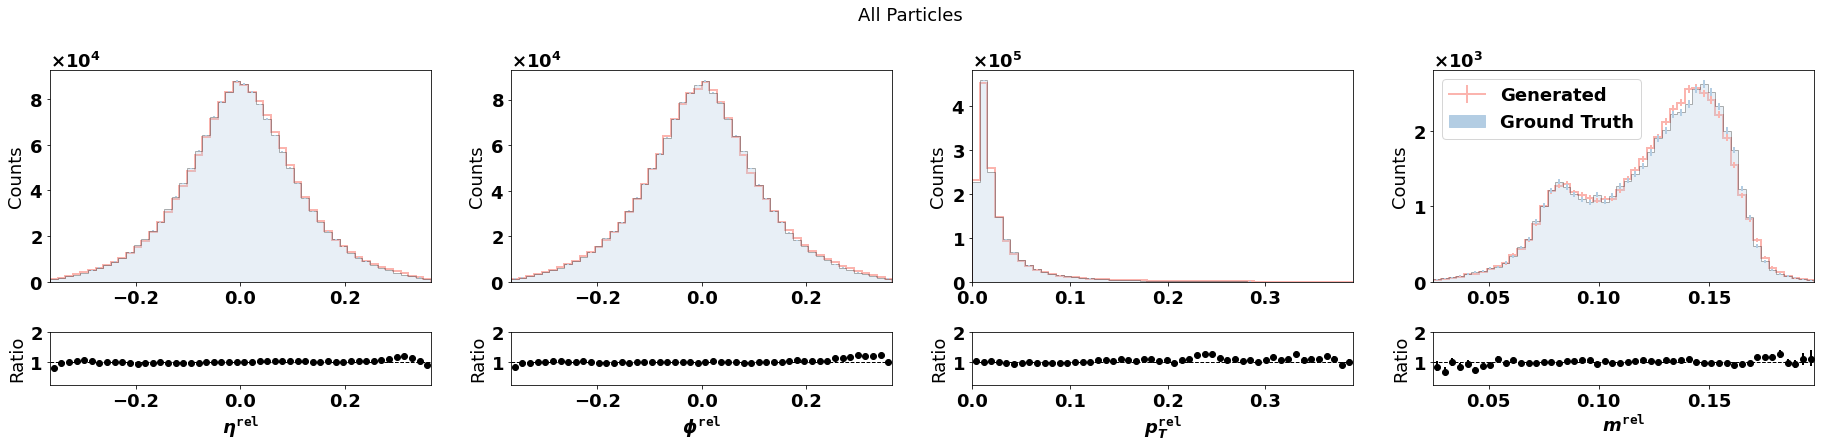

In [24]:
    temp = {"val_fpnd": fpndv,"val_mmd": mmd,"val_cov": cov,"val_w1m": w1m_,
            "val_w1efp": w1efp_,"val_w1p": w1p_,"step": model.global_step,"name":"TF-"+model.config["parton"]}
    print("epoch {}: ".format(model.current_epoch), temp)
    plot = plotting_point_cloud(model=model,gen=fake_scaled.reshape(-1,model.n_current,model.n_dim),
                                     true=true_scaled.reshape(-1,model.n_current,model.n_dim),config=model.config,step=model.global_step,
    logger=None, n=30,p=config["parton"])#,nf=z_scaled.reshape(-1,self.n_current,self.n_dim)
    # self.plot.plot_scores(scores_real,scores_fake,train=True,step=self.global_step)
#     plot.plot_mom(model.global_step)
   
    plot.plot_mass(save=None, bins=50)


In [ ]:
#### import time

n=50000
t=[]
tflow=[]
model.flow=model.flow.to("cuda")
model.gen_net.cuda()
mask=mask.cuda()
c_temp=None
c_temp=c[:n].cuda()
mask_temp=mask[:n]
with torch.no_grad():
    for i in range(10):
        start=time.time()

        z = model.flow.sample(n if model.config["context_features"]==0 else 1,context=c_temp).reshape(n,30,3)
        tflow.append(time.time()-start)
        start=time.time()
        fake = z + model.gen_net(z, mask=mask_temp)
        t.append(time.time()-start)
        del fake
print(np.mean(tflow)/n,np.std(np.array(tflow).reshape(-1)/n))
print(np.mean(t)/n,np.std(np.array(t).reshape(-1)/n))

In [37]:
from tkinter import W
temp_df["name"]=np.array(["TF-t"])
results_df=pd.DataFrame(temp_df.drop("step",axis=1)).copy()

print(results_df)


def format_mean_sd(mean, sd):
    """round mean and standard deviation to most significant digit of sd and apply latex formatting"""
    decimals = -int(np.floor(np.log10(sd)))
    decimals -= int((sd * 10 ** decimals) >= 9.5)

    if decimals < 0:
        ten_to = 10 ** (-decimals)
        if mean > ten_to:
            mean = ten_to * (mean // ten_to)
        else:
            mean_ten_to = 10 ** np.floor(np.log10(mean))
            mean = mean_ten_to * (mean // mean_ten_to)
        sd = ten_to * (sd // ten_to)
        decimals = 0

    if mean >= 1e3 and sd >= 1e3:
        mean = np.round(mean * 1e-3)
        sd = np.round(sd * 1e-3)
        return f"${mean:.{decimals}f}$k $\\pm {sd:.{decimals}f}$k"
    else:
        return f"${mean:.{decimals}f} \\pm {sd:.{decimals}f}$"

# print_table.index=["t"]#"q"
print_table=results_df.copy()
print_table["pmm"]=print_table["val_w1m"].apply(lambda x:x[1])
print_table["val_w1m"]=print_table["val_w1m"].apply(lambda x:x[0])
print_table["pmp"]=print_table["val_w1p"].apply(lambda x:x[1])
print_table["val_w1p"]=print_table["val_w1p"].apply(lambda x:x[0])
print_table["pme"]=print_table["val_w1efp"].apply(lambda x:x[1])
print_table["val_w1efp"]=print_table["val_w1efp"].apply(lambda x:x[0])
print_table.columns=["fpnd","mmd","cov","w1m","w1efp","w1p","name","pmm","pmp","pme"]
cols=["w1m","w1p","w1efp","pmm","pmp","pme","cov","fpndv","mmd"]
print_table["model"]=print_table["name"].str[:-2]
print_table=print_table.set_index("name",drop=False).drop("name",1)
# print_table=print_table[["w1m","w1p","w1efp","fpnd","cov","mmd","pmm","pmp","pme","model"]]

print_table.loc[:,"w1m"]*=1000
print_table.loc[:,"w1p"]*=1000
print_table.loc[:,"w1efp"]*=100000
print_table.loc[:,"pmm"]*=1000
print_table.loc[:,"pmp"]*=1000
print_table.loc[:,"pme"]*=100000
print_table

   val_fpnd  val_mmd  val_cov                                         val_w1m  \
0  0.202447  0.07304    0.573  (0.000731523533221334, 0.00010593801859802473)   

                                         val_w1efp  \
0  (1.3957306556709215e-05, 8.027598061879823e-06)   

                                         val_w1p  name  
0  (0.001637593786465083, 0.0005025867384316623)  TF-t  


/tmp/ipykernel_11336/4140049160.py:41: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  print_table=print_table.set_index("name",drop=False).drop("name",1)


,fpnd,mmd,cov,w1m,w1efp,w1p,pmm,pmp,pme,model
name,,,,,,,,,,
TF-t,0.202447,0.07304,0.573,0.731524,1.395731,1.637594,0.105938,0.502587,0.80276,TF


In [41]:
from tkinter import W
temp_df["name"]=np.array(["TF-t"])
results_df=temp_df.copy()




def format_mean_sd(mean, sd):
    """round mean and standard deviation to most significant digit of sd and apply latex formatting"""
    decimals = -int(np.floor(np.log10(sd)))
    decimals -= int((sd * 10 ** decimals) >= 9.5)

    if decimals < 0:
        ten_to = 10 ** (-decimals)
        if mean > ten_to:
            mean = ten_to * (mean // ten_to)
        else:
            mean_ten_to = 10 ** np.floor(np.log10(mean))
            mean = mean_ten_to * (mean // mean_ten_to)
        sd = ten_to * (sd // ten_to)
        decimals = 0

    if mean >= 1e3 and sd >= 1e3:
        mean = np.round(mean * 1e-3)
        sd = np.round(sd * 1e-3)
        return f"${mean:.{decimals}f}$k $\\pm {sd:.{decimals}f}$k"
    else:
        return f"${mean:.{decimals}f} \\pm {sd:.{decimals}f}$"

# print_table.index=["t"]#"q"
print_table=results_df.copy()
print_table["pmm"]=print_table["val_w1m"].apply(lambda x:x[1])
print_table["val_w1m"]=print_table["val_w1m"].apply(lambda x:x[0])
print_table["pmp"]=print_table["val_w1p"].apply(lambda x:x[1])
print_table["val_w1p"]=print_table["val_w1p"].apply(lambda x:x[0])
print_table["pme"]=print_table["val_w1efp"].apply(lambda x:x[1])
print_table["val_w1efp"]=print_table["val_w1efp"].apply(lambda x:x[0])
print_table.columns=["logprob","fpnd","mmd","cov","w1m","w1efp","w1p","name","pmm","pmp","pme"]
cols=["w1m","w1p","w1efp","pmm","pmp","pme","cov","fpndv","mmd"]
print_table["model"]=print_table["name"].str[:-2]
print_table=print_table.drop("logprob",1).set_index("name",drop=False).drop("name",1)
print_table=print_table[["w1m","w1p","w1efp","fpnd","cov","mmd","pmm","pmp","pme","model"]]

print_table.loc[:,"w1m"]*=1000
print_table.loc[:,"w1p"]*=1000
print_table.loc[:,"w1efp"]*=100000
print_table.loc[:,"pmm"]*=1000
print_table.loc[:,"pmp"]*=1000
print_table.loc[:,"pme"]*=100000
#print_table.loc["MP-MP-g",:]=np.array([0.7,0.9,0.7,0.12,0.56,0.037,0.2,0.3,0.7,"MP-MP"])

#print_table.loc["MPLFC-MP-g",:]=np.array([0.69,1.8,0.9,0.2,0.54,0.037,.07,.3,.2,"MP_LFC-MP"])
#print_table.loc["MP-MP-q",:]=np.array([0.6,4.9,0.7,0.35,0.50,0.026,.2,.5,.4,"MP-MP"])

#print_table.loc["MPLFC-MP-q",:]=np.array([0.7,2.6,0.9,0.08,0.52,0.037,.2,.4,.9,"MP_LFC-MP"])


#print_table.loc["MP-MP-t",:]=np.array([0.6,2.3,2,0.37,0.57,0.071,.2,.3,1,"MP-MP"])
#print_table.loc["MPLFC-MP-t",:]=np.array([0.9,2.2,2,0.93,0.56,0.073,.3,.7,1,"MP_LFC-MP"])
print_table.loc[:,"w1m"]=print_table.apply(lambda x:format_mean_sd(float(x["w1m"]),float(x["pmm"])),axis=1)
print_table.loc[:,"w1efp"]=print_table.apply(lambda x:format_mean_sd(float(x["w1efp"]),float(x["pme"])),axis=1)
print_table.loc[:,"w1p"]=print_table.apply(lambda x:format_mean_sd(float(x["w1p"]),float(x["pmp"])),axis=1)


print_table.loc[:,"cov"]=print_table.loc[:,"cov"].astype(float).map('{:.2f}'.format)
print_table.loc[:,"fpnd"]=print_table.loc[:,"fpnd"].astype(float).map('{:.2f}'.format)
print_table.loc[:,"mmd"]=print_table.loc[:,"mmd"].astype(float).map('{:.3f}'.format)

print_table.loc[:,"pmm"]=print_table.loc[:,"pmm"].astype(float).map('{:,.2f}'.format)

print_table.loc[:,"pmp"]=print_table.loc[:,"pmp"].astype(float).map('{:,.2f}'.format)

print_table.loc[:,"pme"]=print_table.loc[:,"pme"].astype(float).map('{:,.2f}'.format)
print_table.loc[:,"parton"]=print_table.index.str[-1]
# print_table.loc[:,"val_w1m"]="$"+print_table["val_w1m"].map(str)+"\pm"+print_table["pmm"].map(str)+"$"
# print_table.loc[:,"val_w1p"]="$"+print_table["val_w1p"].map(str)+"\pm"+print_table["pmp"].map(str)+"$"
# print_table.loc[:,"val_w1efp"]="$"+print_table["val_w1efp"].map(str)+"\pm"+print_table["pme"].map(str)+"$"
print_table.loc[:,"cov"]="$"+print_table["cov"].map(str)+"$"
print_table.loc[:,"fpnd"]="$"+print_table["fpnd"].map(str)+"$"
print_table.loc[:,"mmd"]="$"+print_table["mmd"].map(str)+"$"

# print_table.loc[:,"model"]=print_table["model"].str.replace("cc0","VNF").str.replace("c0","VNF").str.replace("cc","CCNF").str.replace("c","CNF").str.replace("1","\ (m)").str.replace("2","\ (m,n)").str.replace("q","").str.replace("g","").str.replace("t","")

index=["MP-MP-g","MPLFC-MP-g","TF-g","MP-MP-q","MPLFC-MP-q","TF-q","MP-MP-t","MPLFC-MP-t","TF-t"]
index=["TF-t"]

print_table=print_table.loc[index,:]

final_table=pd.DataFrame()
tex=""
for p in ["t"]:
    temp=print_table[print_table["parton"]==p]

    for col in print_table.drop("model",axis=1).columns:
        
        if col not in ["w1m","w1p","w1efp","fpnd","cov","mmd" ]:
            continue
        
        temp_index=temp[col].str.replace("$","").str.split("\\").str[0].astype(float)
        mins=temp_index==temp_index.min() if col!="cov" else temp_index==temp_index.max()
        temp.loc[mins,col]="$\mathbf{"+temp.loc[mins,col].astype(str).str.replace("$","")+"}$"
    temp=temp[["model","w1m","w1p","w1efp","fpnd","cov","mmd"]]
    temp.columns=["model","$W_1^M (\times 10^{-3})$","$W_1^P (\times 10^{-3})$","$W_1^{EFP}(\times 10^{-5})$","FPND",r"COV $\uparrow$","MMD"]
    text=temp.to_latex(index=False,escape=False)
    parton="Gluon" if p=="g" else "Light Quark" if p=="q" else "Top Quark"
    tex+="\multirow{3}{*}{"+parton+"} & "+text.split("MMD \\\\")[1].split("\\bottomrule")[0].replace("\\\\","\\\\&").replace("\\midrule","").replace("MP_LFC","MP\_LFC").replace("  ","")[:-2]+"\cline{1-8}" 
    tex+="\n"
print(tex)


    #     final_table=final_table.append(temp)

# print(final_table.to_latex(index=False,escape=False))


/tmp/ipykernel_11336/522501066.py:41: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  print_table=print_table.drop("logprob",1).set_index("name",drop=False).drop("name",1)
/tmp/ipykernel_11336/522501066.py:41: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  print_table=print_table.drop("logprob",1).set_index("name",drop=False).drop("name",1)
/tmp/ipykernel_11336/522501066.py:99: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp_index=temp[col].str.replace("$","").str.split("\\").str[0].astype(float)
/tmp/ipykernel_11336/522501066.py:101: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character r

\multirow{3}{*}{Top Quark} & 
 TF & $\mathbf{0.0 \pm 0.1}$ & $\mathbf{0.0 \pm 0.5}$ &$\mathbf{163.8 \pm 0.8}$ & $\mathbf{0.07}$ & $\mathbf{0.00}$ & $\mathbf{0.573}$ \\\cline{1-8}



/tmp/ipykernel_11336/522501066.py:104: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  text=temp.to_latex(index=False,escape=False)


In [25]:
from energyflow.emd import emds
real_jets = true_scaled[:, :, [2, 0, 1]]
gen_jets = fake_scaled[:, :, [2, 0, 1]]
rng = np.random.default_rng()
covs = []
mmds = []
d=[]
for j in  range(10):
    real_rand = rng.choice(len(real_jets), size=100)
    gen_rand = rng.choice(len(gen_jets), size=100)

    real_rand_sample = real_jets[real_rand]
    gen_rand_sample = gen_jets[gen_rand]

    # 2D array of emds, with shape (len(gen_rand_sample), len(real_rand_sample))
    dists = emds(gen_rand_sample, real_rand_sample)
    dists2 =emds(gen_rand_sample, real_rand_sample)
    print(dists.shape)
    d.append(dists-dists2)
d

(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)
(100, 100)


[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 arr

In [24]:
pl.utilities.seed.seed_everything(69)
print(cov_mmd(fake_scaled,true_scaled,))
pl.utilities.seed.seed_everything(69)
print(cov_mmd(true_scaled,fake_scaled,))

Global seed set to 69
Calculating cov and mmd over 10 batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 19.07it/s]
Global seed set to 69


(0.4090000000000001, 0.028491837225168452)


Calculating cov and mmd over 10 batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 19.22it/s]

(0.519, 0.024527042505468118)


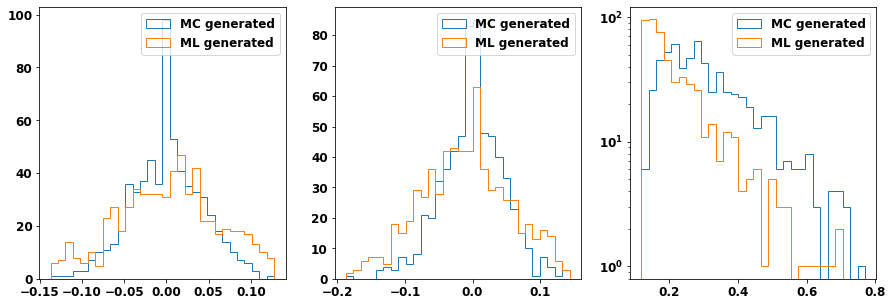

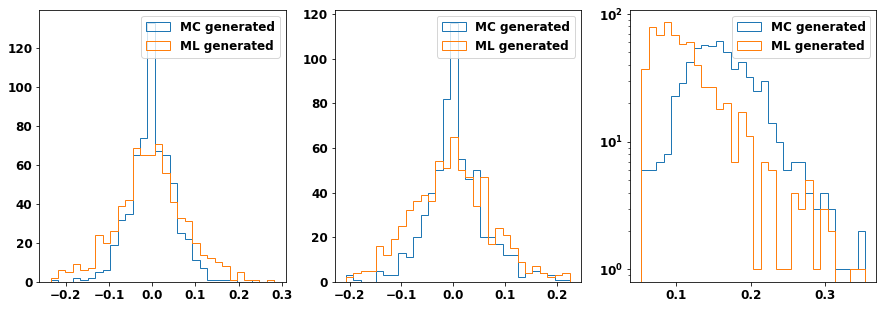

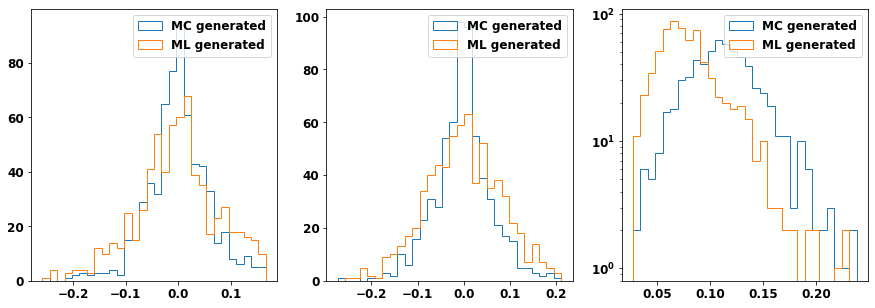

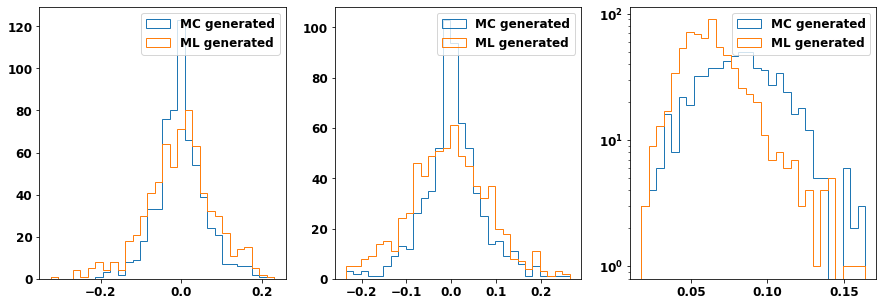

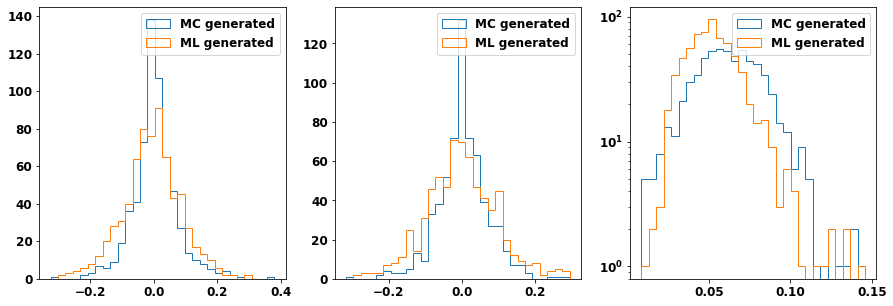

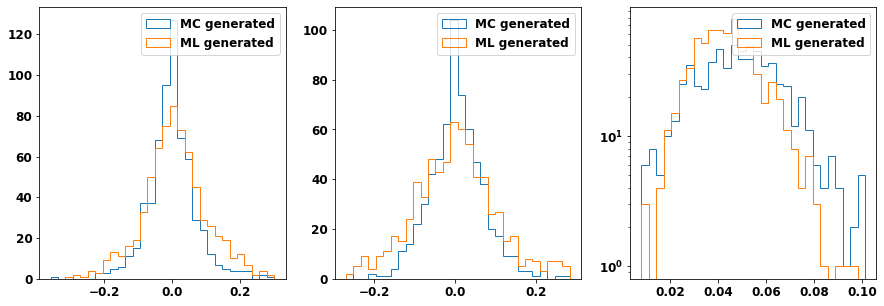

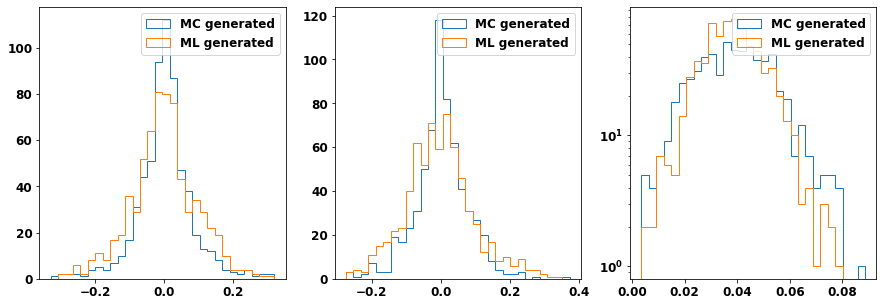

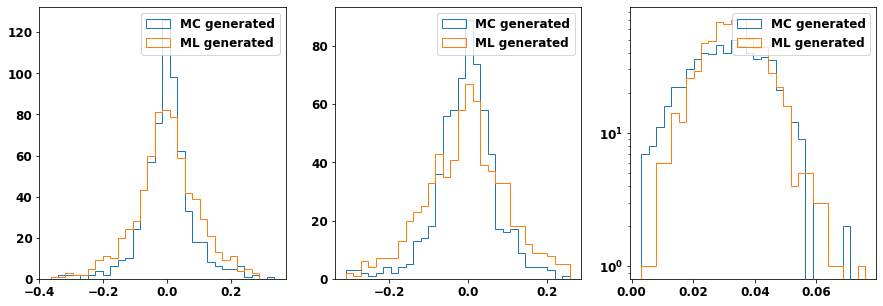

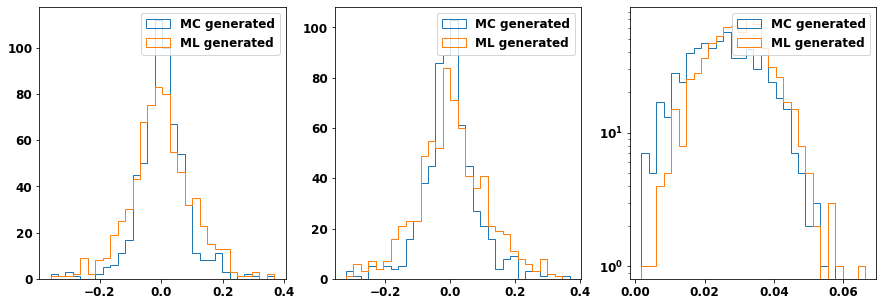

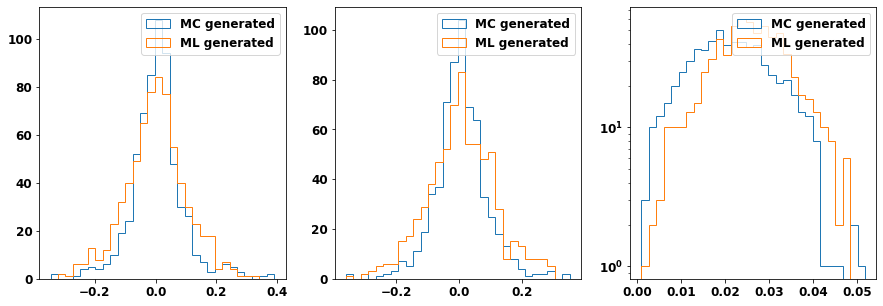

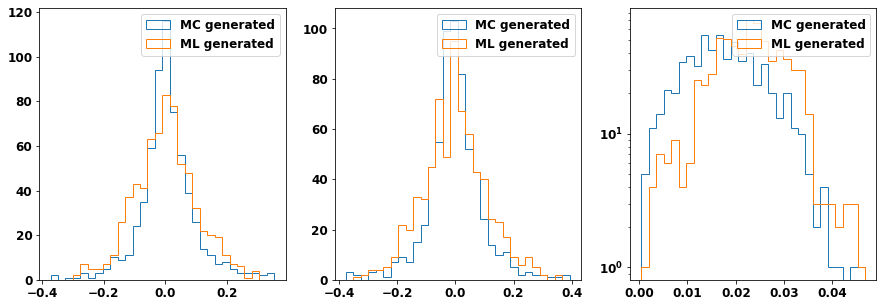

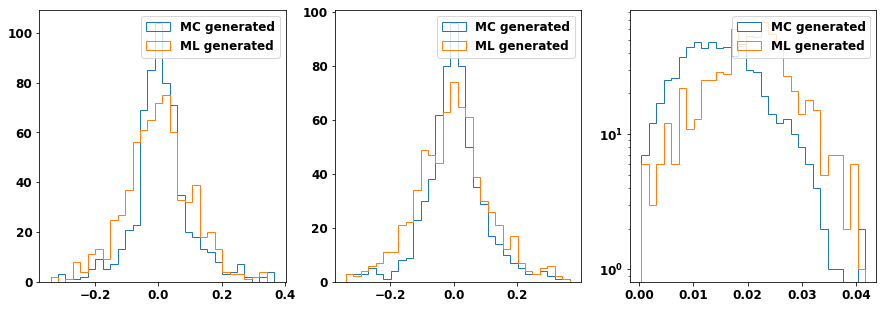

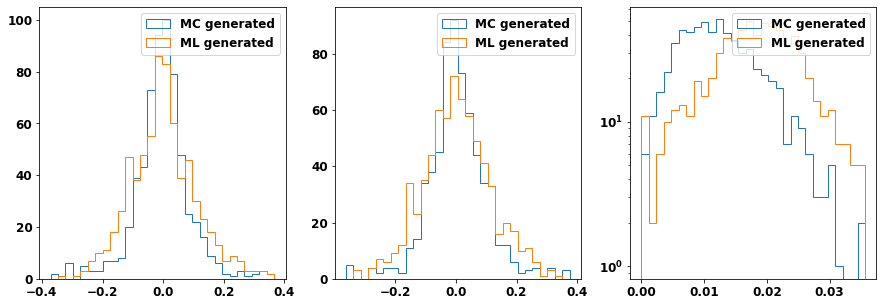

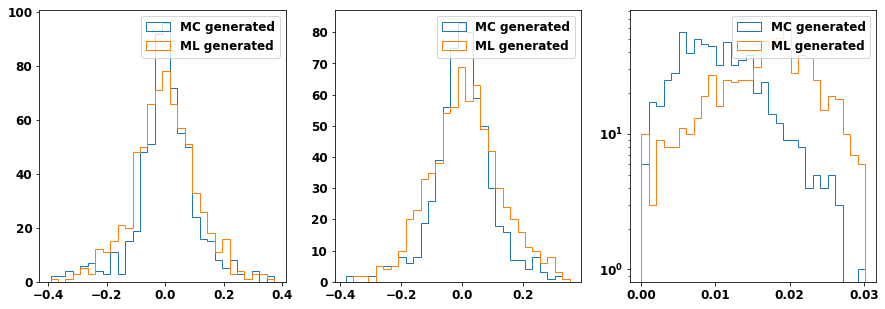

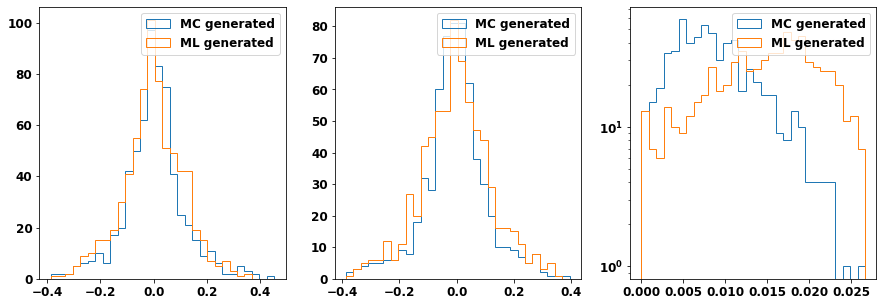

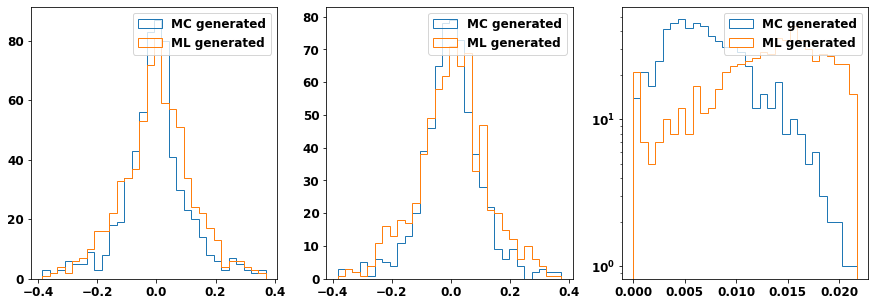

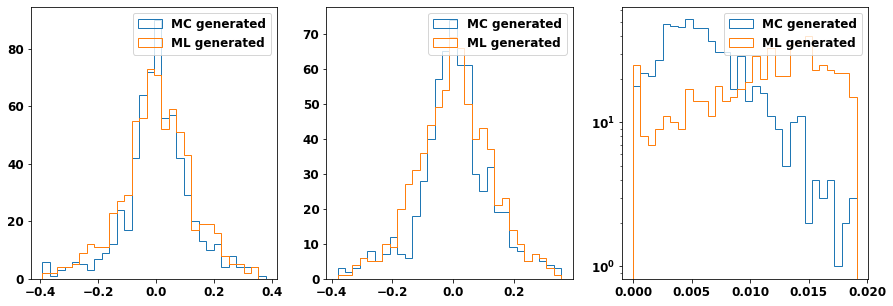

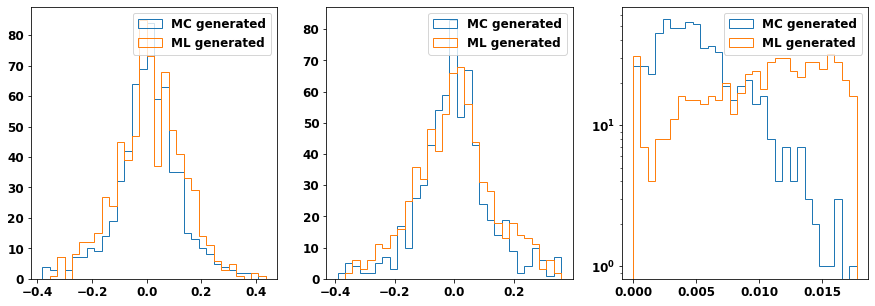

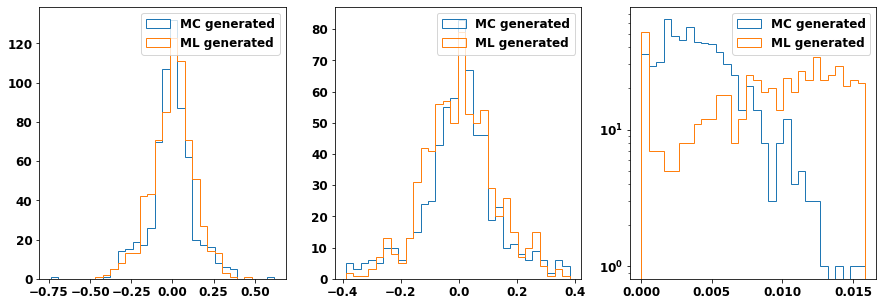

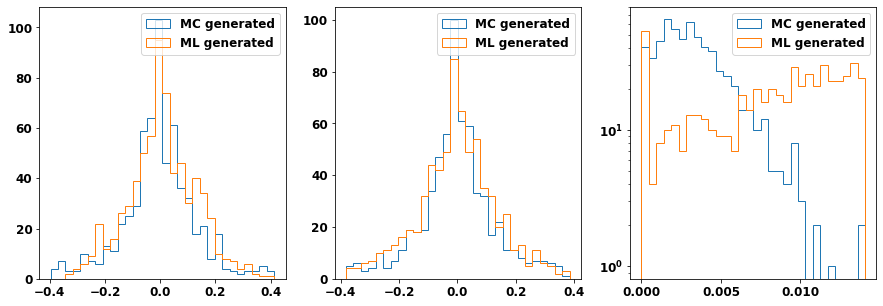

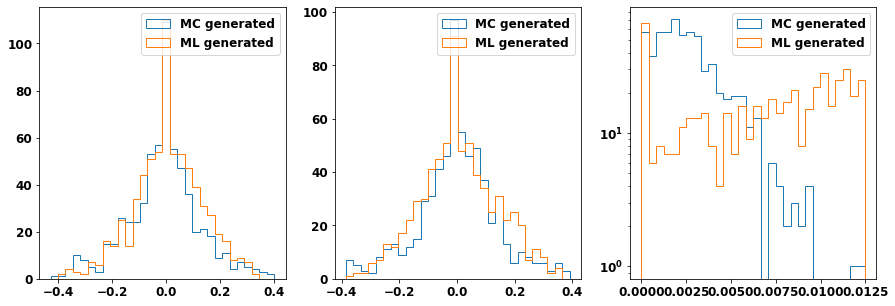

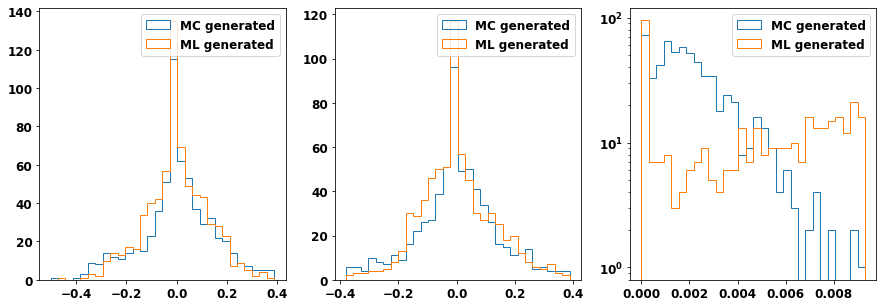

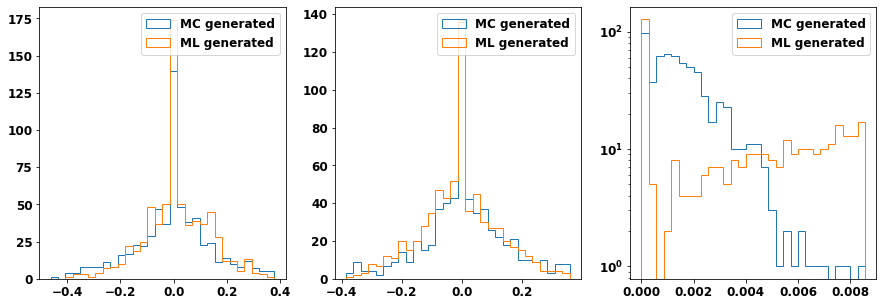

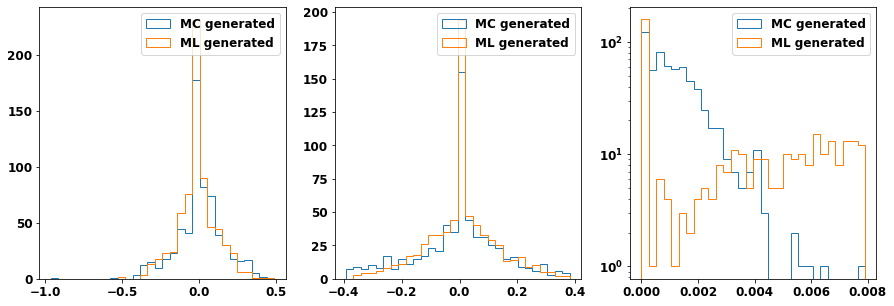

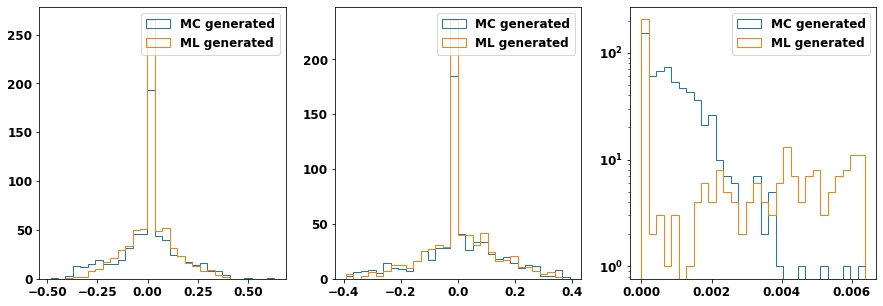

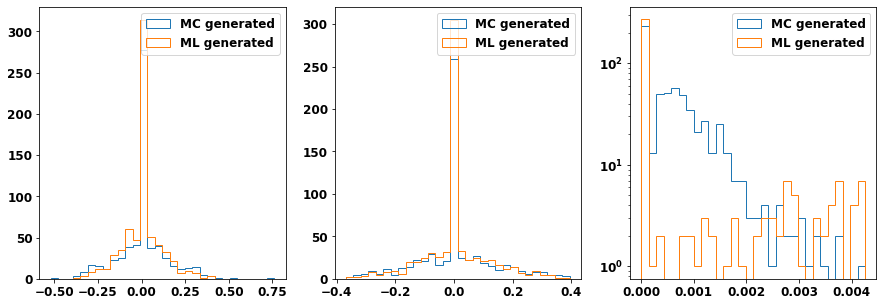

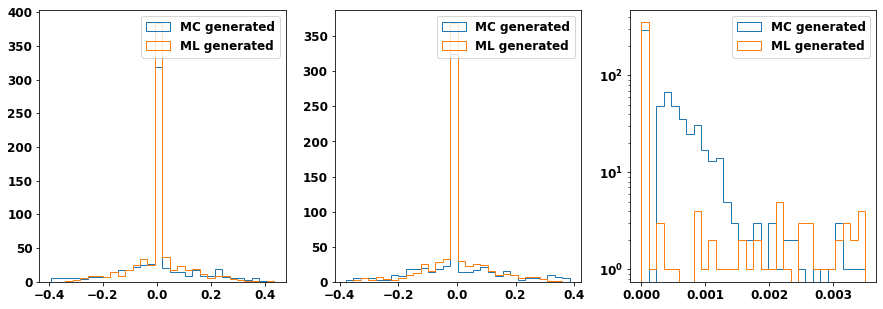

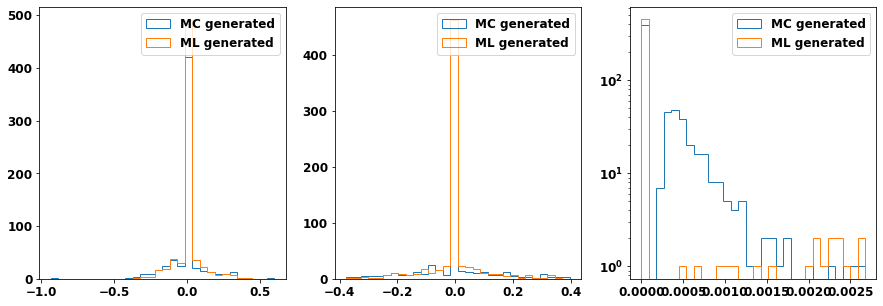

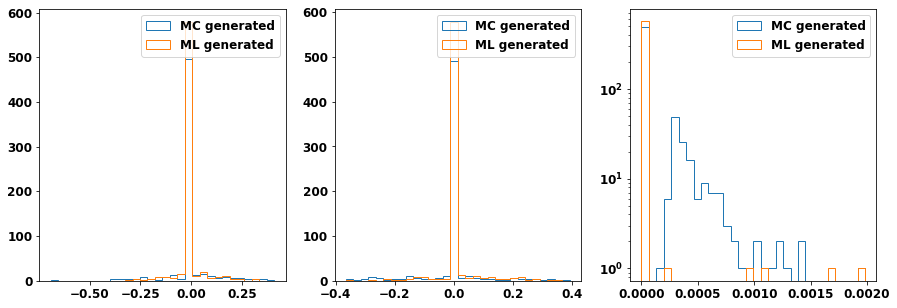

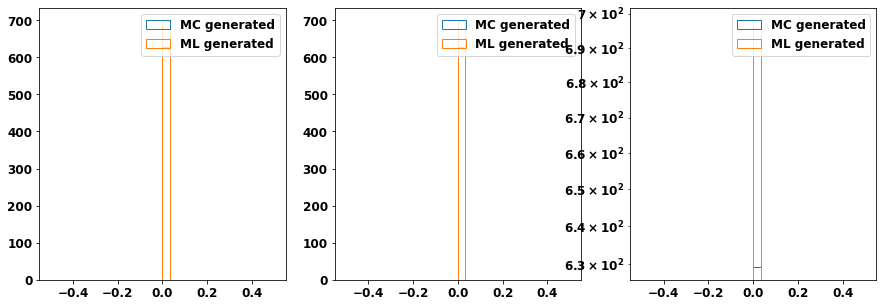

In [4]:
for i in range(30):
    fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(15,5))
    _,b,_=ax[0].hist(true_scaled[mask.sum(axis=1)>0].numpy()[:,i,0],bins=30,histtype="step",label="MC generated")
    _,b,_=ax[0].hist(fake_scaled[mask_test.sum(axis=1)>0].numpy()[:,i,0],bins=b,histtype="step",label="ML generated")
    ax[0].legend()
    _,b,_=ax[1].hist(true_scaled[mask.sum(axis=1)>0].numpy()[:,i,1],bins=30,histtype="step",label="MC generated")
    _,b,_=ax[1].hist(fake_scaled[mask_test.sum(axis=1)>0].numpy()[:,i,1],bins=b,histtype="step",label="ML generated")
    ax[1].legend()
    
    _,b,_=ax[2].hist(true_scaled[mask.sum(axis=1)>0].numpy()[:,i,2],bins=30,histtype="step",label="MC generated")
    _,b,_=ax[2].hist(fake_scaled[mask_test.sum(axis=1)>0].numpy()[:,i,2],bins=b,histtype="step",label="ML generated")
    plt.legend()
    plt.yscale("log")
    plt.show()


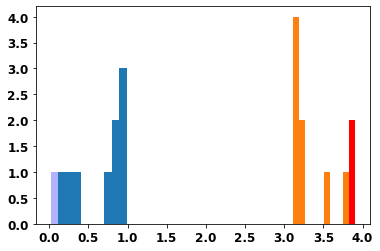

In [5]:
fig,ax=plt.subplots()
_,_,patches=plt.hist(np.random.rand(10))
plt.hist(np.random.rand(10)+3)
ax.patches[0].set_fc("blue")
ax.patches[0].set_alpha(0.3)
ax.patches[-1].set_fc("red")

In [6]:
print_table["parton"]=["t","t","g","q","t"]
print_table

NameError: name 'print_table' is not defined

# Print table for paper


                    w1m_           w1p_         w1efp_   pmm   pmp   pme  \
model                                                                      
TF         $0.7 \pm 0.3$  $0.9 \pm 0.2$  $0.6 \pm 0.4$  0.27  0.21  0.36   
TF         $0.7 \pm 0.1$  $1.3 \pm 0.6$  $0.6 \pm 0.5$  0.14  0.59  0.55   
TF         $0.8 \pm 0.2$  $1.4 \pm 0.2$      $3 \pm 1$  0.17  0.23  1.06   
MP-MP      $0.6 \pm 0.2$  $2.3 \pm 0.3$      $2 \pm 1$  0.20  0.30  1.00   
MP_LFC-MP  $0.9 \pm 0.3$  $2.2 \pm 0.7$      $2 \pm 1$  0.30  0.70  1.00   

              cov   fpndv      mmd parton      model  
model                                                 
TF         $0.55$  $0.06$  $0.038$      t         TF  
TF         $0.51$  $0.08$  $0.026$      t         TF  
TF         $0.57$  $0.08$  $0.072$      t         TF  
MP-MP      $0.57$  $0.37$  $0.071$      t      MP-MP  
MP_LFC-MP  $0.56$  $0.93$  $0.073$      t  MP_LFC-MP  


/tmp/ipykernel_56435/3254530464.py:89: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  for col in print_table.drop("model",1).columns:
/tmp/ipykernel_56435/3254530464.py:94: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp_index=temp[col].str.replace("$","").str.split("\\").str[0].astype(float)
/tmp/ipykernel_56435/3254530464.py:96: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp.loc[mins,col]="$\mathbf{"+temp.loc[mins,col].astype(str).str.replace("$","")+"}$"


\multirow{7}{*}{Top Quark} & 
MP-MP & $\mathbf{0.6 \pm 0.2}$ &$2.3 \pm 0.3$ & $2 \pm 1$ &$0.37$ & $\mathbf{0.57}$ &$0.071$ \\&

MP\_LFC-MP &$0.9 \pm 0.3$ &$2.2 \pm 0.7$ & $2 \pm 1$ &$0.93$ &$0.56$ &$0.073$ \\&
 TF &$0.7 \pm 0.3$ & $\mathbf{0.9 \pm 0.2}$ &$\mathbf{0.6 \pm 0.4}$ & $\mathbf{0.06}$ &$0.55$ &$0.038$ \\&
 TF &$0.7 \pm 0.1$ &$1.3 \pm 0.6$ &$\mathbf{0.6 \pm 0.5}$ &$0.08$ &$0.51$ & $\mathbf{0.026}$ \\&
 TF &$0.8 \pm 0.2$ &$1.4 \pm 0.2$ & $3 \pm 1$ &$0.08$ & $\mathbf{0.57}$ &$0.072$ \\\cline{1-8}



/tmp/ipykernel_56435/3254530464.py:99: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  text=temp.to_latex(index=False,escape=False)


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

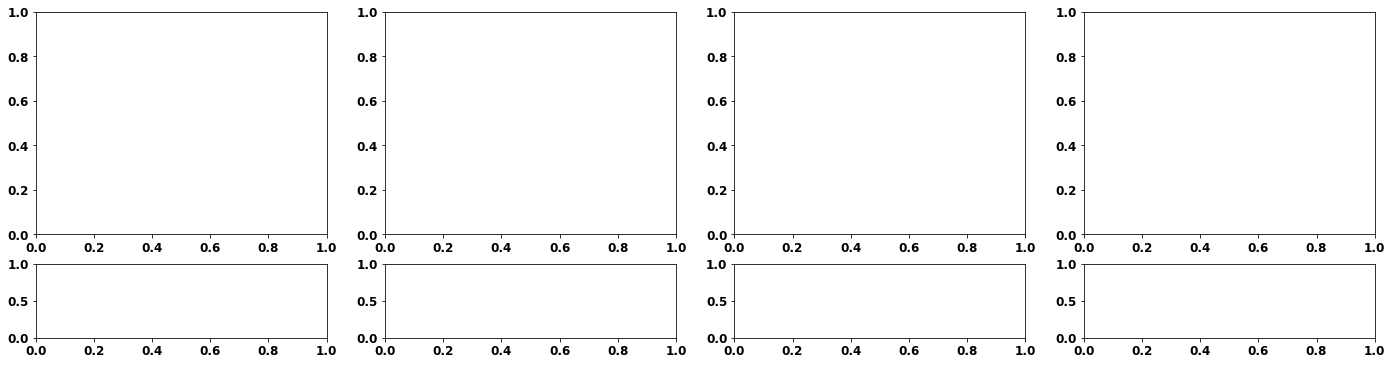

In [ ]:
m_t = mass(
        true_scaled[:, : model.n_dim * model.n_part].to(model.device),
        model.config["canonical"],
    ).cpu()
m_gen = mass(z_scaled[:, : model.n_dim * model.n_part], model.config["canonical"]).cpu()
m_c = mass(fake_scaled[:, : model.n_dim * model.n_part], model.config["canonical"]).cpu()
plot=plotting_paper(true_scaled,fake_scaled,config,0,"t",model=model)
plot.plot_mass(m_c,m_t,save=False,quantile=False,bins=50,plot_vline=False,title="")


In [ ]:
torch.triu(torch.ones(30,30))-torch.diag(torch.ones(30))

tensor([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0.